In [1]:
import os
import numpy as np
from matplotlib import pylab as plt
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import utils
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
train_dataset=ImageFolder(root='../input/animefaces/two_dimensions',
                         transform=transforms.Compose([
                             transforms.Resize(96),
                             transforms.ToTensor(),#(C,H,W),0-1
                             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                         ]))
#ImageFolder返回tuple(图片,所属类别)
train_images=data.DataLoader(train_dataset,batch_size=128,shuffle=True,num_workers=2)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# real_batch=next(iter(train_images))#获得迭代器对象并返回下一个值
# plt.figure(figsize=(8,8))
# plt.axis('off')
# plt.title('Training images')
# plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64],padding=2,normalize=True).cpu(),(1,2,0)))

In [4]:
def weights_init(m):
    classname=m.__class__.__name__
    if classname.find('Conv')!=-1:
        nn.init.normal_(m.weight.data,0,0.02)
    elif classname.find('BatchNorm')!=-1:
        nn.init.normal_(m.weight.data,1,0.02)
        nn.init.constant_(m.bias.data,0)

In [5]:
gf=64
df=64
nz=100
nc=3

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main=nn.Sequential(
            nn.ConvTranspose2d(nz,gf*8,kernel_size=6,stride=1,padding=0,bias=False),
            nn.BatchNorm2d(gf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(gf*8,gf*4,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(gf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(gf*4,gf*2,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(gf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(gf*2,gf,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(gf),
            nn.ReLU(True),
            nn.ConvTranspose2d(gf,nc,kernel_size=4,stride=2,padding=1,bias=False),
            nn.Tanh()
        )
    
    def forward(self,x):
        return self.main(x)

In [7]:
netG=Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(6, 6), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main=nn.Sequential(
            nn.Conv2d(nc,df,kernel_size=4,stride=2,padding=1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(df,df*2,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(df*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(df*2,df*4,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(df*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(df*4,df*8,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(df*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(df*8,1,kernel_size=6,stride=1,padding=0,bias=False),
            nn.Sigmoid()#(128,1,1,1)
        )
    
    def forward(self,x):
        return self.main(x)

In [9]:
netD=Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(6, 6), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [10]:
fixed_noise=torch.randn(64,nz,1,1,device=device)
real_label=1
fake_label=0
#loss and optimizer
criterion=nn.BCELoss()
optimizerD=torch.optim.Adam(netD.parameters(),lr=0.0002,betas=(0.5,0.999))
optimizerG=torch.optim.Adam(netG.parameters(),lr=0.0002,betas=(0.5,0.999))

> *First, we will construct a batch of real samples from the training set, forward pass through (D), calculate the loss (log(D(x))), then calculate the gradients in a backward pass. **Secondly**, we will construct a batch of fake samples with the current generator, forward pass this batch through (D), calculate the loss (log(1-D(G(z)))), and accumulate the gradients with a backward pass. Now, with the gradients accumulated from both the all-real and all-fake batches, we call a step of the Discriminator’s optimizer.*

> *As stated in the original paper, we want to train the Generator by minimizing (log(1-D(G(z)))) in an effort to generate better fakes. As mentioned, this was shown by Goodfellow to not provide sufficient gradients, especially early in the learning process. As a fix, we instead wish to maximize (log(D(G(z)))). In the code we accomplish this by: classifying the Generator output from Part 1 with the Discriminator, computing G’s loss using real labels as GT, computing G’s gradients in a backward pass, and finally updating G’s parameters with an optimizer step. It may seem counter-intuitive to use the real labels as GT labels for the loss function, but this allows us to use the (log(x)) part of the BCELoss (rather than the (log(1-x)) part) which is exactly what we want.*

> *Finally, we will do some statistic reporting and at the end of each epoch we will push our fixed_noise batch through the generator to visually track the progress of G’s training. *

In [11]:
img_list=[]
G_losses=[]
D_losses=[]
iters=0
print('Start training...')

for epoch in range(100):
    for i,data in enumerate(train_images):
        #########################################
        #(1)updata D,max log(D(x))+log(1-D(G(z)))
        #########################################
        #Train with all_real batch
        optimizerD.zero_grad()
        real_data=data[0].to(device)#(128,3,96,96)
        b_size=real_data.size(0)
        label=torch.full((b_size,),real_label,device=device)#(128,)
        output=netD(real_data).view(-1)#(128,1,1,1)-->(128,)
        errD_real=criterion(output,label)
        errD_real.backward()
        D_x=output.mean().item()
        
        #Train with all_fake batch
        noise=torch.randn(b_size,nz,1,1,device=device)
        fake=netG(noise)
        label.fill_(fake_label)
        output=netD(fake).view(-1)#detach()截断反向传播的梯度流,该节点前面的梯度不再更新
        errD_fake=criterion(output,label)
        errD_fake.backward()
        D_G_z1=output.mean().item()
        
        #update D
        errD=errD_real+errD_fake
        optimizerD.step()
        
        #################################################
        #(1)updata G,min log(1-D(G(z)))-->max log D(G(z))
        #################################################
        optimizerG.zero_grad()
        label.fill_(real_label)
        fake=netG(noise)
        output=netD(fake).view(-1)
        errG=criterion(output,label)
        errG.backward()
        D_G_z2=output.mean().item()
        
        optimizerG.step()
        
        #...
        if i%40==0:
            print('[%d/%d][%d/%d]\tLoss_D:%.4f\tLoss_G:%.4f\tD(x):%.4f\tD(G(z)):%.4f/%.4f'
                   %(epoch,20,i,len(train_images),errD.item(),errG.item(),D_x,D_G_z1,D_G_z2))
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (iters%100==0) or ((epoch==20-1) and (i==len(train_images)-1)):
            with torch.no_grad():
                fake=netG(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake,padding=2,normalize=True))
            
        iters+=1

Start training...
[0/20][0/401]	Loss_D:2.6868	Loss_G:3.7925	D(x):0.2813	D(G(z)):0.4749/0.0411
[0/20][40/401]	Loss_D:0.0019	Loss_G:32.2827	D(x):0.9983	D(G(z)):0.0000/0.0000
[0/20][80/401]	Loss_D:1.2412	Loss_G:11.6204	D(x):0.8016	D(G(z)):0.2824/0.0002
[0/20][120/401]	Loss_D:0.5773	Loss_G:5.7990	D(x):0.8996	D(G(z)):0.2619/0.0071
[0/20][160/401]	Loss_D:0.7399	Loss_G:4.4749	D(x):0.8066	D(G(z)):0.0947/0.0279
[0/20][200/401]	Loss_D:0.6214	Loss_G:3.7300	D(x):0.7832	D(G(z)):0.0805/0.0705
[0/20][240/401]	Loss_D:1.5298	Loss_G:10.0662	D(x):0.9684	D(G(z)):0.6639/0.0005
[0/20][280/401]	Loss_D:0.5361	Loss_G:3.6128	D(x):0.7291	D(G(z)):0.0772/0.0470
[0/20][320/401]	Loss_D:0.8391	Loss_G:7.7418	D(x):0.8303	D(G(z)):0.3434/0.0013
[0/20][360/401]	Loss_D:0.5497	Loss_G:5.0038	D(x):0.7105	D(G(z)):0.0285/0.0215
[0/20][400/401]	Loss_D:0.7399	Loss_G:6.0101	D(x):0.8126	D(G(z)):0.2977/0.0044
[1/20][0/401]	Loss_D:0.5481	Loss_G:3.9699	D(x):0.7473	D(G(z)):0.1138/0.0438
[1/20][40/401]	Loss_D:0.4560	Loss_G:4.5724	D(x):0

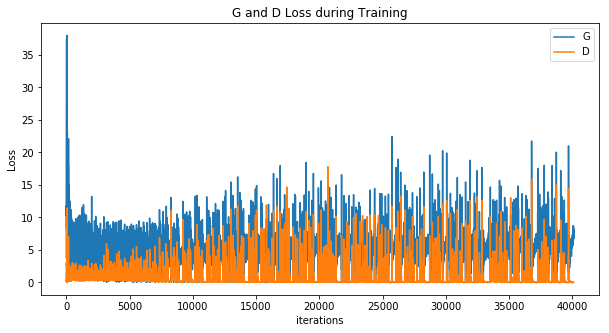

In [12]:
plt.figure(figsize=(10,5))
plt.title('G and D Loss during Training')
plt.plot(G_losses,label='G')
plt.plot(D_losses,label='D')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# fig=plt.figure(figsize=(8,8))
# plt.axis('off')
# ims=[[plt.imshow(np.transpose(i,(1,2,0)),animated=True)] for i in img_list]
# ani=animation.ArtistAnimation(fig,ims,interval=1000,repeat_delay=1000,blit=True)
# HTML(ani.to_jshtml())

In [14]:
real_batch=next(iter(train_images))
plt.figure(figsize=(200,200))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Real Images')
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64],padding=5,normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis('off')
plt.title('Fake Images')
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [15]:
!nvidia-smi

OSError: [Errno 12] Cannot allocate memory